In [1]:
%load_ext autoreload

%autoreload 2
    
import geomeffibem
import openstudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f"OS: {openstudio.openStudioLongVersion()}, E+ {openstudio.energyPlusVersion()}+{openstudio.energyPlusBuildSHA()}"

'OS: 3.9.0+c77fbb9569, E+ 24.2.0+94a887817b'

# Make a toy model

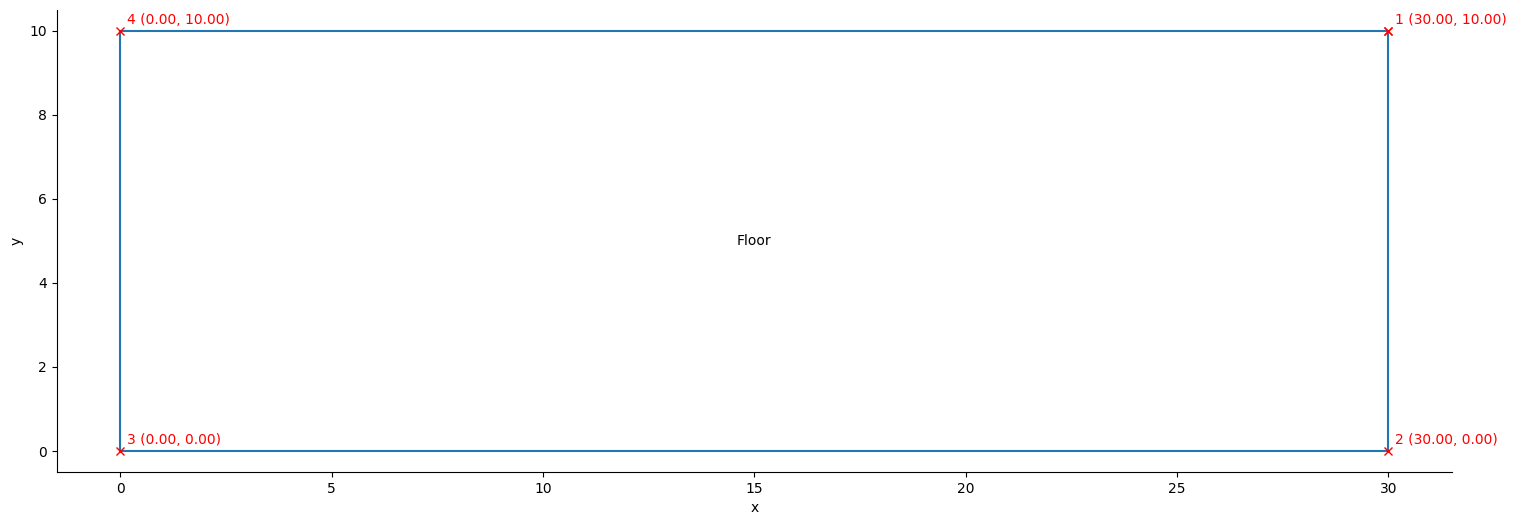

In [3]:
min_x = 0.0
max_x = 30.0
min_y = 0.0
max_y = 10.0
min_z = 0.0
max_z = 3.0 # Floor height

floor_surface = geomeffibem.Surface.Floor(min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y, z=min_z)
floor_surface.name = 'Floor'
ax = floor_surface.plot()

In [4]:
m = openstudio.model.Model()
b = m.getBuilding()
b.setNorthAxis(0.0)
s = openstudio.model.Space.fromFloorPrint(floor_surface.to_Point3dVector(), max_z, m).get()
z = openstudio.model.ThermalZone(m)
s.setName("Space1")
s.setThermalZone(z)
z.setName("Zone1")

c = openstudio.model.Construction(m)
c.setName("R13 Construction")
mat = openstudio.model.MasslessOpaqueMaterial(m)
mat.setName("R13-IP")
mat.setThermalResistance(openstudio.convert(13, "ft^2*h*R/Btu","m^2*K/W").get())
c.setLayers([mat])

True

In [5]:
for sf in s.surfaces():
    sf.setConstruction(c)
    if sf.surfaceType() == 'Floor':
        sf.setName("FLOOR")
    elif sf.surfaceType() == 'RoofCeiling':
        sf.setName("ROOF")
    else:
        print(openstudio.radToDeg(sf.azimuth()), end=" => ")
        
        group = sf.planarSurfaceGroup().get()
        site_transformation = group.siteTransformation()
        site_vertices = site_transformation * sf.vertices()
        site_outward_normal = openstudio.getOutwardNormal(site_vertices).get()
        north = openstudio.Vector3d(0.0,1.0,0.0)
        if site_outward_normal.x() < 0.0:
            azimuth = 360.0 - openstudio.radToDeg(openstudio.getAngle(site_outward_normal, north))
        else:
            azimuth = openstudio.radToDeg(openstudio.getAngle(site_outward_normal, north))
        
        if (azimuth >= 315.0 or azimuth < 45.0):
            facade = "4-North"
        elif (azimuth >= 45.0 and azimuth < 135.0):
            facade = "3-East"
        elif (azimuth >= 135.0 and azimuth < 225.0):
            facade = "1-South"
        elif (azimuth >= 225.0 and azimuth < 315.0):
            facade = "2-West"
            
        print(azimuth, facade)
        sf.setName(f"{facade}".upper())  # - Abs azimuth {azimuth:.2f}".upper())

90.0 => 90.0 3-East
180.0 => 180.0 1-South
270.0 => 270.0 2-West
0.0 => 0.0 4-North


## Split wall

In [6]:
s_wall = m.getSurfaceByName('1-SOUTH').get()

<Axes: xlabel='x', ylabel='z'>

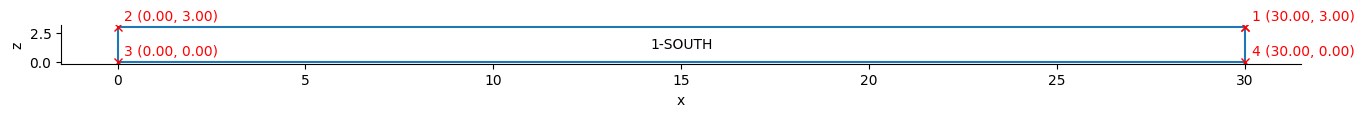

In [7]:
fig, ax = plt.subplots(figsize=(16, 0.5))
wall = geomeffibem.Surface.from_Surface(s_wall)
wall.plot(ax=ax)

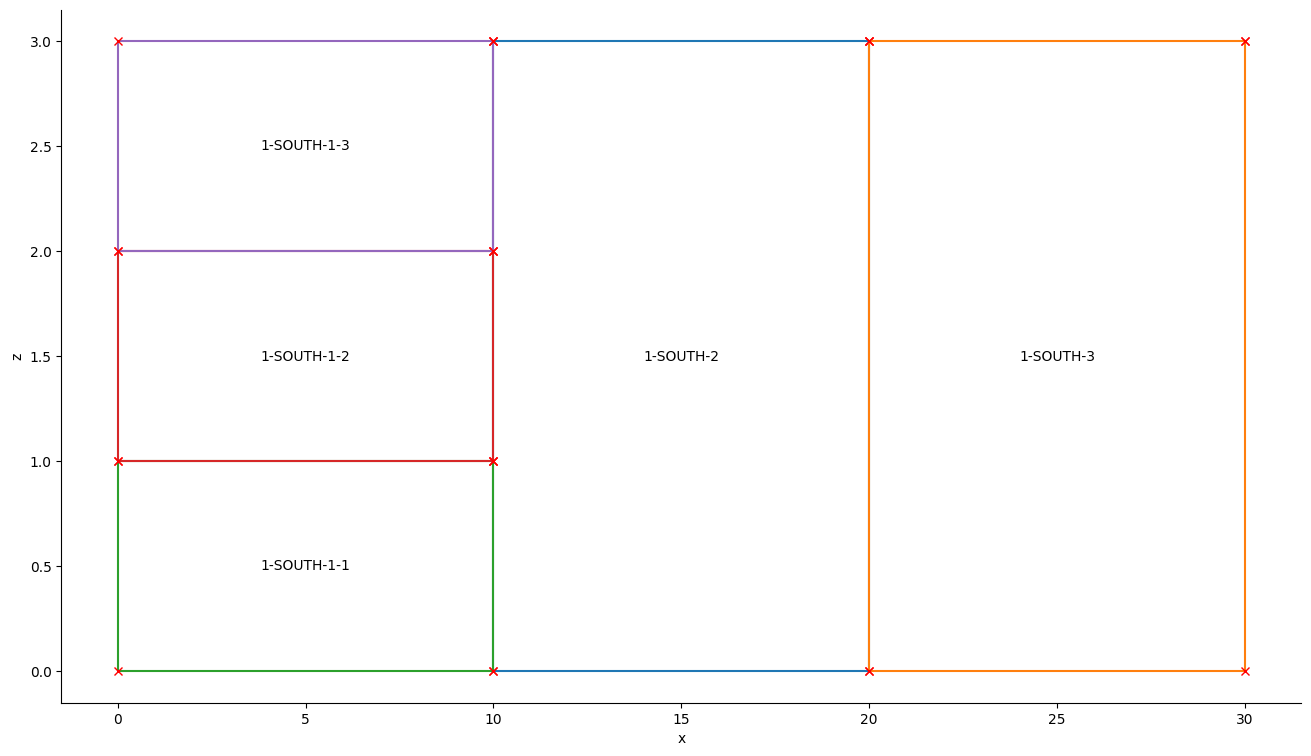

In [8]:
xsfs = wall.split_into_n_segments(n_segments=3, axis='x')
zsfs = xsfs[0].split_into_n_segments(n_segments=3, axis='z')
new_walls = xsfs[1:] + zsfs

fig, ax = plt.subplots(figsize=(16, 9))
for new_sf in new_walls:
    new_sf.plot(ax=ax, annotate=False) #, with_os_centroid=True)

**Commit the changes to the model**

In [9]:
s_wall.remove()
for new_wall in new_walls:
    s_new_wall = openstudio.model.Surface(new_wall.to_Point3dVector(), m)
    s_new_wall.setName(new_wall.name)
    s_new_wall.setSpace(s)
    s_new_wall.setConstruction(c)

## Forward translate

In [10]:
diag = m.getOutputDiagnostics()
diag.enableDisplayExtraWarnings()

True

In [11]:
ft = openstudio.energyplus.ForwardTranslator()
ft.setExcludeHTMLOutputReport(False)
ft.setExcludeLCCObjects(True)
ft.setKeepRunControlSpecialDays(True)
ft.setExcludeSpaceTranslation(True)
ft.setExcludeVariableDictionary(True)
ft.setExcludeSQliteOutputReport(True)

In [12]:
w = ft.translateModel(m)

[openstudio.model.YearDescription] <1> 'UseWeatherFile' is selected in YearDescription, but there are no weather file set for the model.
[openstudio.model.YearDescription] <1> 'UseWeatherFile' is selected in YearDescription, but there are no weather file set for the model.


# Polyhedron: is Zone Enclosed?

This should be available in openstudio directly soonish: https://github.com/NREL/OpenStudio/pull/4592

In [13]:
zonePoly = geomeffibem.Polyhedron([geomeffibem.Surface.from_Surface(s) for s in m.getSurfaces()])

In [14]:
isEnclosed, edgesNot2 = zonePoly.isEnclosedVolume()
isEnclosed

Updating Polyhedron with collinear vertices on lines


True

## Get some details

In [15]:
edgesNot2orig, edges2orig = geomeffibem.Polyhedron.edgesNotTwoForEnclosedVolumeTest(zonePoly=zonePoly)

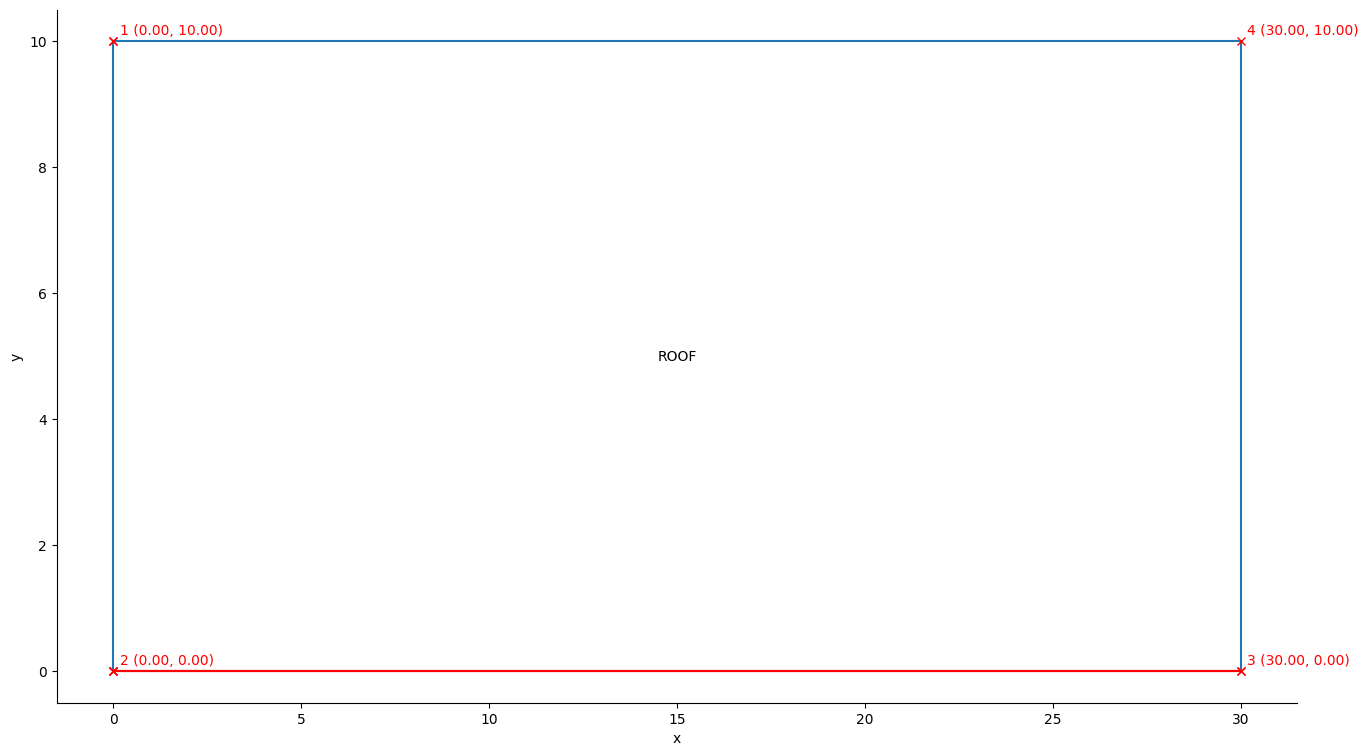

In [16]:
roof_edges = [x for x in edgesNot2orig if 'ROOF' in x.allSurfaces[0].name]
assert(len(roof_edges) == 1)
roof_edges[0].plot_on_first_surface()

In [17]:
wall_edges = [x for x in edgesNot2orig if 'SOUTH' in x.allSurfaces[0].name]
wall_edges

[start=(+10.0000, +0.0000, +3.0000), end=(+0.0000, +0.0000, +3.0000), count=1, firstSurface=1-SOUTH-1-3,
 start=(+0.0000, +0.0000, +3.0000), end=(+0.0000, +0.0000, +2.0000), count=1, firstSurface=1-SOUTH-1-3,
 start=(+10.0000, +0.0000, +2.0000), end=(+10.0000, +0.0000, +3.0000), count=1, firstSurface=1-SOUTH-1-3,
 start=(+0.0000, +0.0000, +2.0000), end=(+0.0000, +0.0000, +1.0000), count=1, firstSurface=1-SOUTH-1-2,
 start=(+10.0000, +0.0000, +1.0000), end=(+10.0000, +0.0000, +2.0000), count=1, firstSurface=1-SOUTH-1-2,
 start=(+0.0000, +0.0000, +1.0000), end=(+0.0000, +0.0000, +0.0000), count=1, firstSurface=1-SOUTH-1-1,
 start=(+0.0000, +0.0000, +0.0000), end=(+10.0000, +0.0000, +0.0000), count=1, firstSurface=1-SOUTH-1-1,
 start=(+10.0000, +0.0000, +0.0000), end=(+10.0000, +0.0000, +1.0000), count=1, firstSurface=1-SOUTH-1-1,
 start=(+20.0000, +0.0000, +3.0000), end=(+10.0000, +0.0000, +3.0000), count=1, firstSurface=1-SOUTH-2,
 start=(+10.0000, +0.0000, +3.0000), end=(+10.0000, +0.0

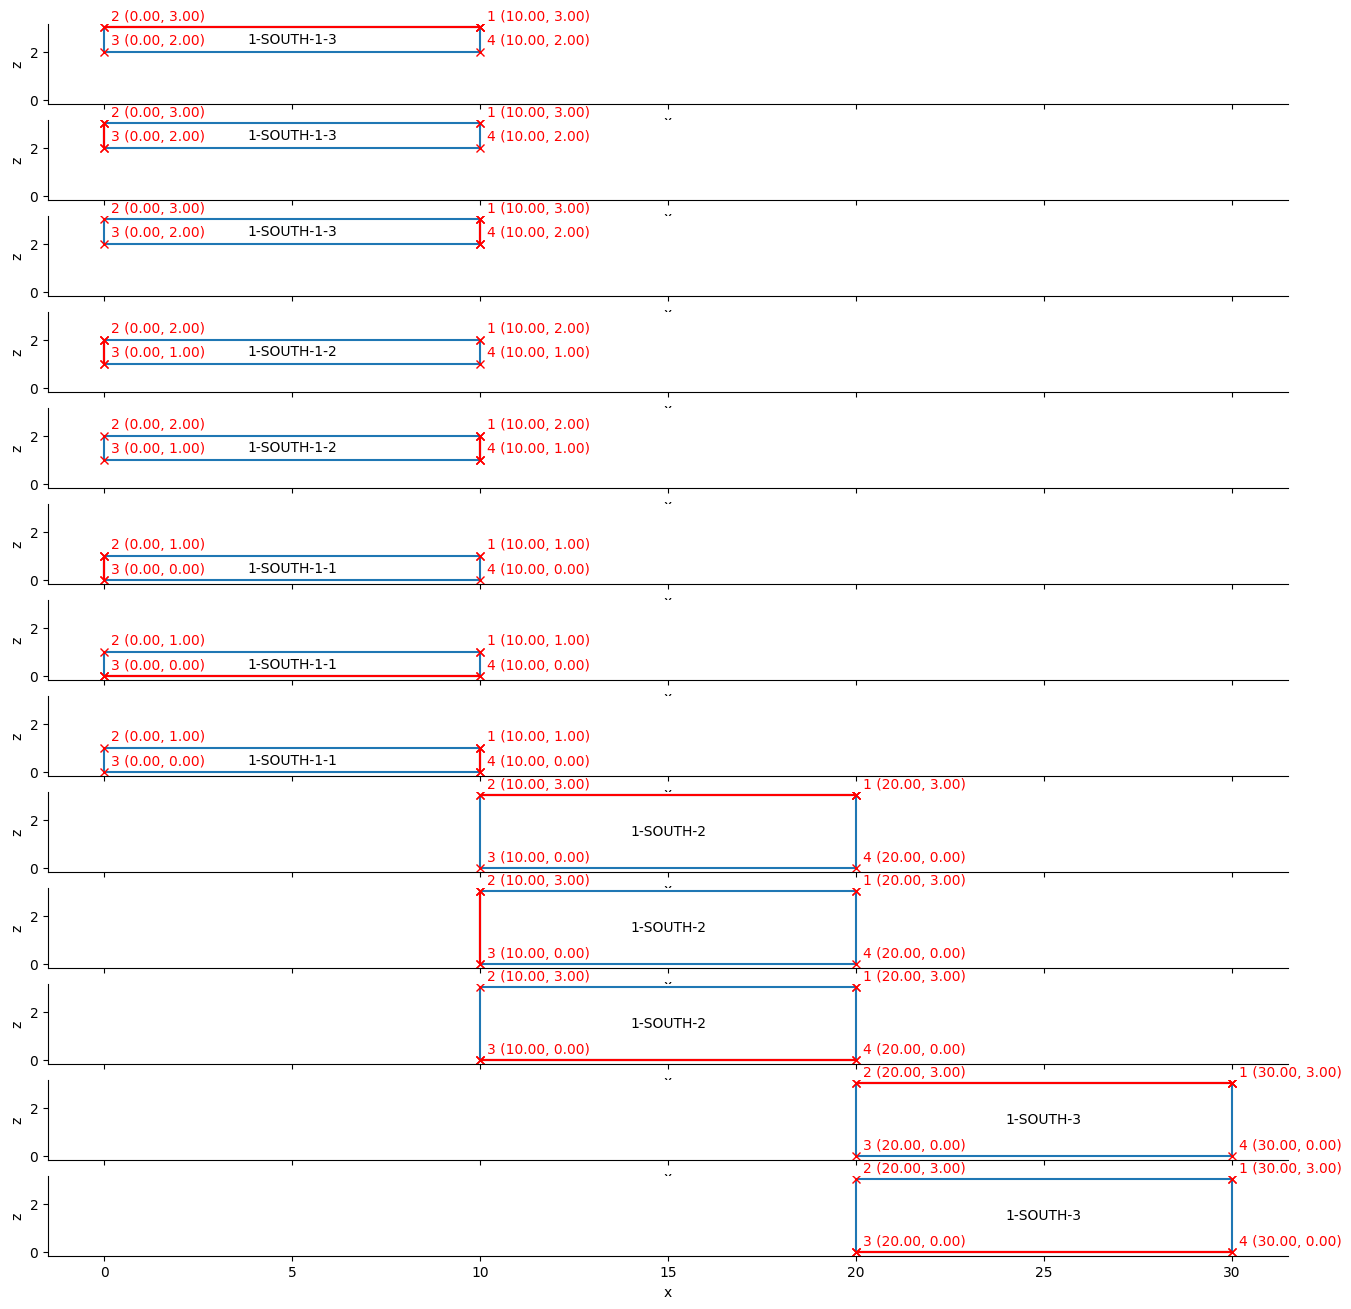

In [18]:
fig, axes = plt.subplots(nrows=len(wall_edges), figsize=(16, 16), sharex=True, sharey=True)
for edge, ax in zip(wall_edges, axes.flatten()):
    edge.plot_on_first_surface(ax=ax)